# Fine Tuning Phase des zuvor trainierten Modells

In [1]:
import arrow
import learn2learn as l2l
import numpy as np
import os
import pickle
import torch
from torch.nn import Module, Linear, Sequential, ReLU
from torch.nn.functional import mse_loss
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils.evalUtils import print_confusion_matrix

from sklearn.preprocessing import MinMaxScaler

In [2]:
%run -i ./scripts/setConfigs.py

Set configs..


## Read Models
### Meta-AE M_1

In [19]:
from models.SimpleAutoEncoder import SimpleAutoEncoder
num_inpus = 17
val_lambda = 42 * 0.01

meta_model = SimpleAutoEncoder(num_inputs=num_inpus, val_lambda=val_lambda)

model_name = '20200319_firstMetaModel.pt'
model_fn = os.path.join(model_bib_path, model_name)
print(model_fn)

/home/torge/dev/masterthesis_code/02_Experimente/MetaLearning/models/model_bib/20200319_firstMetaModel.pt


### LogReg Meta

In [4]:
%run -i ./scripts/ReadLogReg_Meta.py

Load trained LogReg..
LogisticRegression(C=1.0, class_weight={1: 2.0}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


## Load & Prepare Data

In [5]:
data_fn = os.path.join(data_path, 'simulation_data_y_2020_2021_reduced.h5')
df_data_train = pd.read_hdf(data_fn, key='df')
print('Shape of X_train data: {}'.format(df_data_train.shape))

Shape of X_train data: (105216, 17)


In [6]:
data_fn = os.path.join(data_path, 'anomalous_data_y_2022_reduced.h5')
df_data_anormal = pd.read_hdf(data_fn, key='df')
print('Shape of X_test data: {}'.format(df_data_anormal.shape))

Shape of X_test data: (35040, 18)


In [7]:
s_labels = df_data_anormal['label']
df_data_anormal.drop('label', axis=1, inplace=True)
print('Shape of X_test data: {}'.format(df_data_anormal.shape))

Shape of X_test data: (35040, 17)


In [8]:
data_fn = os.path.join(data_path, 'drifted_data_y_2023_reduced_more_cos_phi.h5')
df_data_drifted = pd.read_hdf(data_fn, key='df')
print('Shape of X_drifted data: {}'.format(df_data_drifted.shape))

Shape of X_drifted data: (35040, 18)


In [9]:
s_drift_labels_x_drifted = df_data_drifted['drift_labels']
df_data_drifted.drop('drift_labels', axis=1, inplace=True)
print('Shape of X_drifted data: {}'.format(df_data_drifted.shape))

Shape of X_drifted data: (35040, 17)


In [10]:
print('Scale data..')
scaler_train = MinMaxScaler((-1,1))
scaler_train = scaler_train.fit(df_data_train)
scaled_train = scaler_train.transform(df_data_train.to_numpy())
scaled_anormal = scaler_train.transform(df_data_anormal.to_numpy())
scaled_drifted = scaler_train.transform(df_data_drifted.to_numpy())

Scale data..


In [11]:
# build tensor from numpy
anormal_torch_tensor = torch.from_numpy(scaled_anormal).type(torch.FloatTensor)

drifted_torch_tensor_X = torch.from_numpy(scaled_drifted).type(torch.FloatTensor)

# Fine Tuning Phase

## Prepare Datasets

In [12]:
# build tensor from numpy
print(drifted_torch_tensor_X is None)
drifted_torch_tensor_y = torch.from_numpy(s_drift_labels_x_drifted.to_numpy().reshape(len(s_drift_labels_x_drifted),1)).type(torch.FloatTensor)

False


In [13]:
# build pytorch dataset from tensor
drifted_dataset = TensorDataset(drifted_torch_tensor_X, drifted_torch_tensor_y)

## Do fine tuning!

In [14]:
load_pretraind_model = False

In [15]:
if load_pretraind_model:
    %run -i ./scripts/ReadSimpleAE_MetaModel.py

In [16]:
from MetaLearner.Learner import Learner

In [17]:
learner = Learner(model=meta_model)

In [20]:
learner.do_fine_tuning(fine_tune_data=drifted_dataset, maml_trained_model=meta_model, weight_fn=model_fn, do_debug=True, fine_tune_drift_class=[1], k_shot_fine_tune=10)

  0%|          | 0/100 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++
Done pretraining: False
------------------------------
Fine tune optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
------------------------------
k Shot fine tune: 10
------------------------------
Selected Classes: [1]
------------------------------
Fine tune DataLoader available: True
++++++++++++++++++++++++++++++


Avg Inner Loss: 91416.187012: 100%|██████████| 100/100 [00:08<00:00, 12.20it/s]  


In [21]:
loss_fine_tuned = learner.loss_fine_tune

In [22]:
s_losses_fine_tuned = pd.Series(loss_fine_tuned)

In [23]:
s_losses_fine_tuned.describe()

count    1.000000e+03
mean     3.717266e+06
std      3.192035e+07
min      1.024701e+04
25%      3.714729e+04
50%      1.075558e+05
75%      1.499602e+05
max      3.729751e+08
dtype: float64

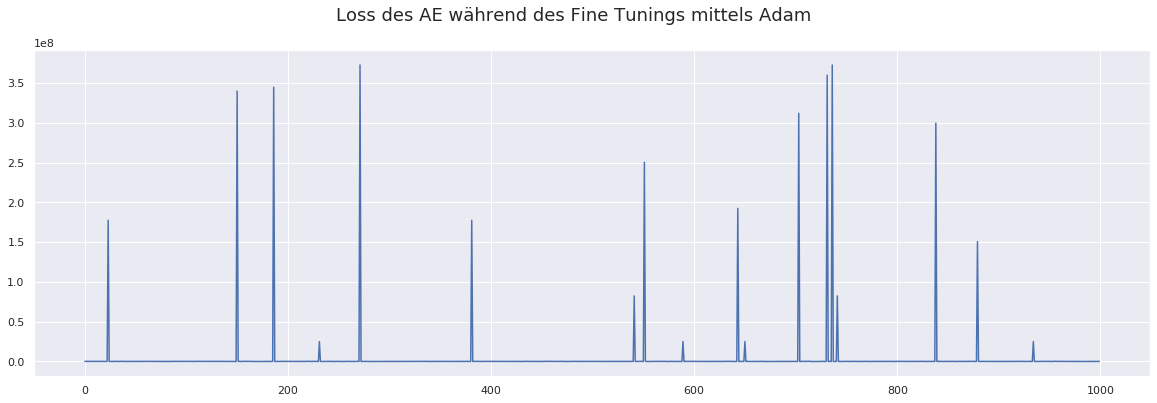

In [24]:
save = False
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
ax.plot(loss_fine_tuned)
fig.suptitle('Loss des AE während des Fine Tunings mittels Adam', fontsize=18)

if save:
    fn = os.path.join(fig_path, 'loss_after_meta_learning.pdf')
    fig.savefig(fn, bbox_inches='tight', pad_inches=0)

## Evaluate fine tuned model

In [25]:
tuned_model = learner.maml_trained_model

In [27]:
encoder_l0_i0 = learner.weight_matrices_trained_meta_model['encoder'][0]['0.weight']
encoder_l0_i1 = learner.weight_matrices_trained_meta_model['encoder'][1]['0.weight']
diff_l0 = encoder_l0_i0 - encoder_l0_i1
diff_l0

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [28]:
weights_meta_model_after = {
    'encoder_l0': tuned_model.encoder[0].weight.detach().numpy().T,
    'encoder_l1': tuned_model.encoder[2].weight.detach().numpy().T,
    'decoder_l0': tuned_model.decoder[0].weight.detach().numpy(),
    'decoder_l1': tuned_model.decoder[2].weight.detach().numpy()
}

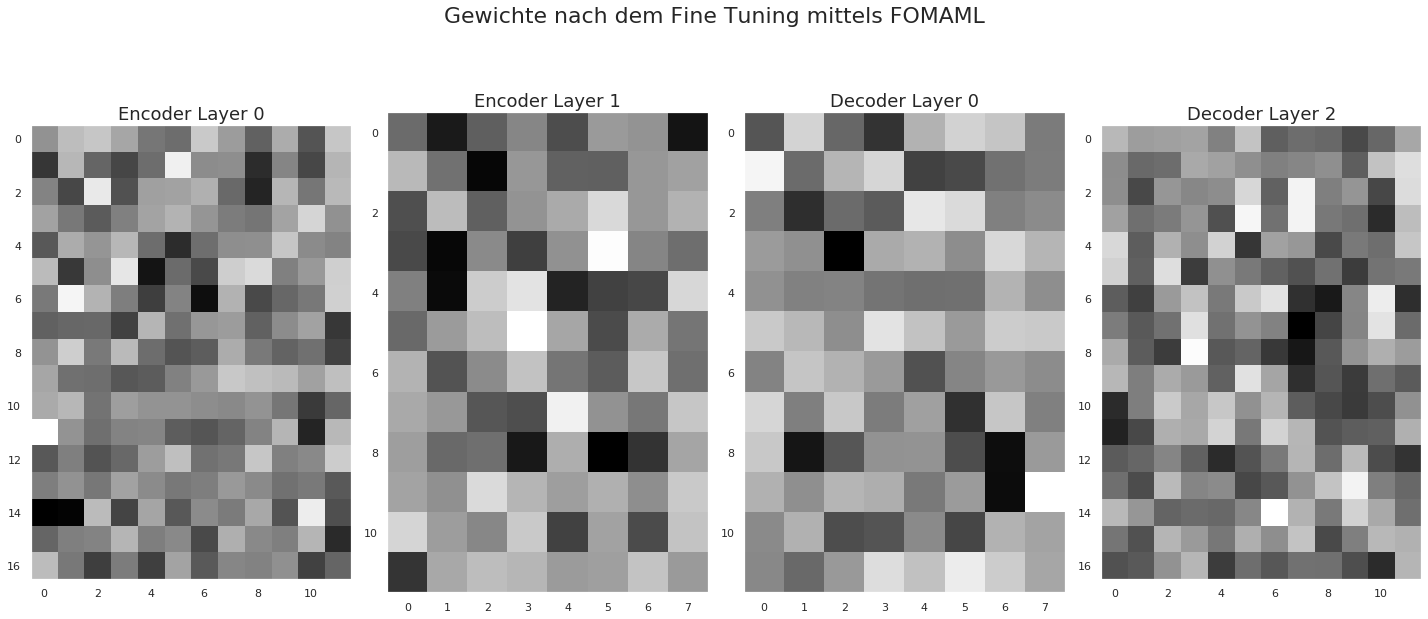

In [29]:
fig, ax = plt.subplots(ncols=4, nrows=1)
fig.set_size_inches(20, 10)

ax[0].imshow(weights_meta_model_after['encoder_l0'], cmap="gray")
ax[0].grid(False)
ax[0].set_title('Encoder Layer 0', fontsize=18)

ax[1].imshow(weights_meta_model_after['encoder_l1'], cmap="gray")
ax[1].grid(False)
ax[1].set_title('Encoder Layer 1', fontsize=18)

ax[2].imshow(weights_meta_model_after['decoder_l0'], cmap="gray")
ax[2].grid(False)
ax[2].set_title('Decoder Layer 0', fontsize=18)

ax[3].imshow(weights_meta_model_after['decoder_l1'], cmap="gray")
ax[3].grid(False)
ax[3].set_title('Decoder Layer 2', fontsize=18)
fig.suptitle('Gewichte nach dem Fine Tuning mittels FOMAML', fontsize=22)
plt.tight_layout()
filename = os.path.join(fig_path, 'gewichte_nach_fine_tuning.pdf')
fig.savefig(filename, bbox_inches = 'tight', pad_inches = 0 )

In [40]:
losses_drifted_tuned = []
for val in drifted_torch_tensor_X:
    loss = tuned_model.calc_reconstruction_error(val)
    losses_drifted_tuned.append(loss.item())
    
s_losses_drifted_tuned = pd.Series(losses_drifted_tuned)

In [41]:
X_drifted_tuned = s_losses_drifted_tuned.to_numpy()
X_drifted_tuned = X_drifted_tuned.reshape(-1, 1)
y_drifted_tuned = np.zeros(len(X_drifted_tuned))

In [42]:
predictions_X_drifted_tuned = []
for val in X_drifted_tuned:
    val = val.reshape(1,-1)
    pred = clf_meta.predict(val)
    predictions_X_drifted_tuned.append(pred[0])

In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from mlxtend.plotting import plot_confusion_matrix
from utils.evalUtils import calc_cm_metrics
from utils.evalUtils import print_confusion_matrix

In [44]:
cm_tuned = confusion_matrix(y_drifted_tuned, predictions_X_drifted_tuned)
tn_tuned, fp_tuned, fn_tuned, tp_tuned  = confusion_matrix(y_drifted_tuned, predictions_X_drifted_tuned).ravel()

In [45]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp_tuned, tn_tuned, fp_tuned, fn_tuned)
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Specifity: {:.4f}'.format(specifity))
print('Sensitivity: {:.4f}'.format(sensitivity))
print('F1-Score: {:.4f}'.format(f1_score))

Accuracy: 90.5137
Precision: 0.0000
Specifity: 100.0000
Sensitivity: 0.0000
F1-Score: 0.0000


Text(0.5, 0.98, 'Confusion Matrix X_drifted')

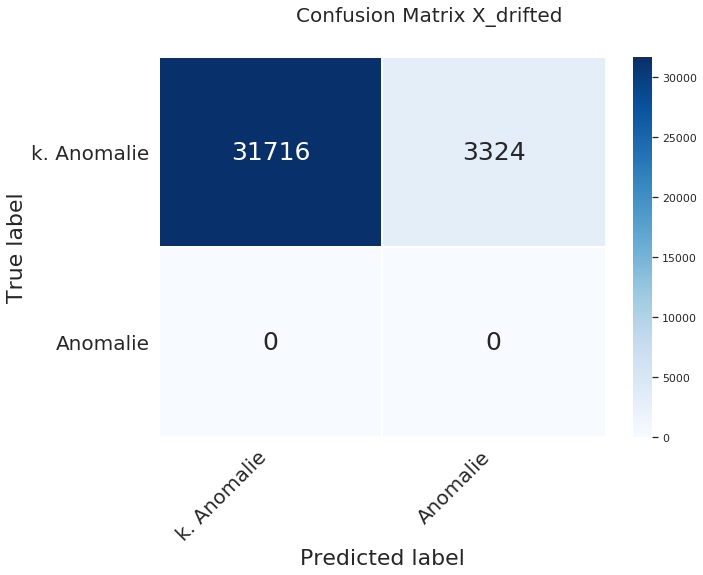

In [46]:
fig = print_confusion_matrix(cm_tuned, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix X_drifted', fontsize=20)

## Save fine-tuned Model

In [47]:
type(tuned_model)

models.SimpleAutoEncoder.SimpleAutoEncoder

In [48]:
model_fn = '{}_FineTunedMetaModel.pt'.format(arrow.now().format('YYYYMMDD'))
print('Model Name: {}'.format(model_fn))
torch.save(tuned_model.state_dict(), os.path.join(model_bib_path, model_fn))

Model Name: 20200324_FineTunedMetaModel.pt
